# Credit Card Fraud Detection with Machine Learning

## Project Overview

This project simulates a real-world scenario for a data analyst working with a financial services client.

A credit card provider wants to automate fraud detection by identifying unusual transaction patterns that may indicate fraudulent activity. The dataset includes historical credit card transactions labeled as legitimate or fraudulent.

Detecting fraud early reduces financial loss, protects customer accounts, and improves trust in the company’s fraud management system.

## Problem Statement

Use transaction data to predict whether a credit card charge is fraudulent and support real-time risk detection.

## Objective

The objective is to build and evaluate classification models that detect fraud using features such as transaction amount, time, and anonymized behavior signals. The project includes data cleaning, exploratory analysis, and model comparisons with a focus on handling class imbalance and minimizing false negatives.


## Dataset Overview

The dataset contains credit card transactions made by European cardholders over two days in 2013. It includes 284,807 records with 30 features—most of which have been anonymized for confidentiality.

The target variable `Class` indicates whether a transaction is legitimate (`0`) or fraudulent (`1`). Fraudulent cases are extremely rare (~0.17%), making this a highly imbalanced classification problem.

The original dataset is available on [Kaggle: Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).

Note: All analysis below was conducted on the full dataset. For reproducibility, a smaller sample is included in this repo due to GitHub file size limitations. To run with the full dataset, you may use [KaggleHub](https://github.com/Kaggle/kagglehub) to download `creditcard.csv` directly from [Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) using the Kaggle API. 

## Importing Libraries

In [2]:
## Importing Libraries

# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Enable inline plots
%matplotlib inline


## Data Loading and Initial Exploration

In this section, we load the dataset and perform a quick inspection to understand its structure, dimensions, and data types.


In [ ]:
# Load dataset

# Option 1: Load from local sampled dataset (included in repo)
# Recommended for GitHub viewers
data_path = "../data/creditcard_sample.csv"
df = pd.read_csv(data_path)

# Option 2: Download full dataset directly from Kaggle (requires Kaggle API key)
# Uncomment the lines below if running locally or in an internet-enabled notebook

# !pip install kagglehub  # Uncomment if KaggleHub is not installed
# import kagglehub
# file_path = kagglehub.download_dataset_file(
#     dataset="mlg-ulb/creditcardfraud",
#     file_name="creditcard.csv"
# )
# df = pd.read_csv(file_path)

# Basic shape
print(f"Dataset contains {df.shape[0]:,} rows and {df.shape[1]} columns.")

# Preview first few rows
df.head()


Dataset contains 284,807 rows and 31 columns.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# Checking the column names & data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### Initial Observations

- The dataset includes 284,807 transactions and 31 columns
- No missing values were detected
- Features `V1` to `V28` are anonymized using PCA
- `Time` and `Amount` are the only interpretable features
- `Class` is the binary target: 0 = legitimate, 1 = fraud


## Data Cleaning and Preprocessing

This section focuses on checking for duplicates, inspecting class imbalance, and preparing the dataset for modeling.

In [8]:
# Check for duplicate rows
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")


Number of duplicate rows: 1081


In [9]:
# Drop duplicate rows
df = df.drop_duplicates()

# Confirm updated shape
print(f"New dataset shape: {df.shape}")


New dataset shape: (283726, 31)


In [10]:
# Check class distribution
df['Class'].value_counts(normalize=True).round(4) * 100


Class
0    99.83
1     0.17
Name: proportion, dtype: float64

- Legitimate transactions (`Class = 0`) make up 99.83% of the data
- Fraudulent transactions (`Class = 1`) account for only 0.17%
- The extreme imbalance requires careful handling during model training and evaluation



Before modeling, we prepare the dataset by removing irrelevant features and standardizing the remaining ones. Feature scaling helps improve model performance, especially for algorithms like SVM that are sensitive to the magnitude of input values.


In [21]:
# Drop 'Time' 
df.drop('Time', axis=1, inplace=True)

# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Standardize entire feature set
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Optional: normalize for SVM
X_normalized = normalize(X_scaled, norm='l1')


In [22]:
df.head()


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Pre processing Summary

- `Time` column was dropped, as it doesn't contribute meaningfully to fraud detection
- All remaining features (including `Amount`) were standardized using StandardScaler
- Feature matrix (`X`) and target vector (`y`) were defined
- An L1-normalized version of `X` was created for use with SVM models


## Exploratory Data Analysis (EDA)

In this section, we explore the class distribution and examine feature behavior to identify patterns that may help distinguish fraudulent transactions from legitimate ones.


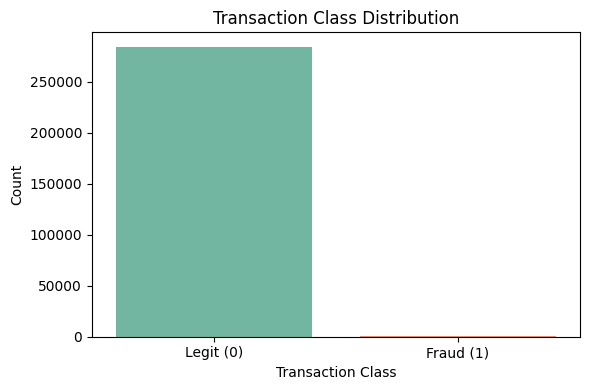

In [30]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', hue='Class', data=df, palette='Set2', legend=False)
plt.title('Transaction Class Distribution')
plt.xticks([0, 1], ['Legit (0)', 'Fraud (1)'])
plt.xlabel('Transaction Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


- Legitimate transactions vastly outnumber fraudulent ones
- Only ~0.17% of transactions are labeled as fraud
- The dataset is highly imbalanced, which affects model training and evaluation


Next we explore feature behaviour by class. We'll start with Amount, since it’s the only interpretable feature and often shows interesting trends in fraud cases.

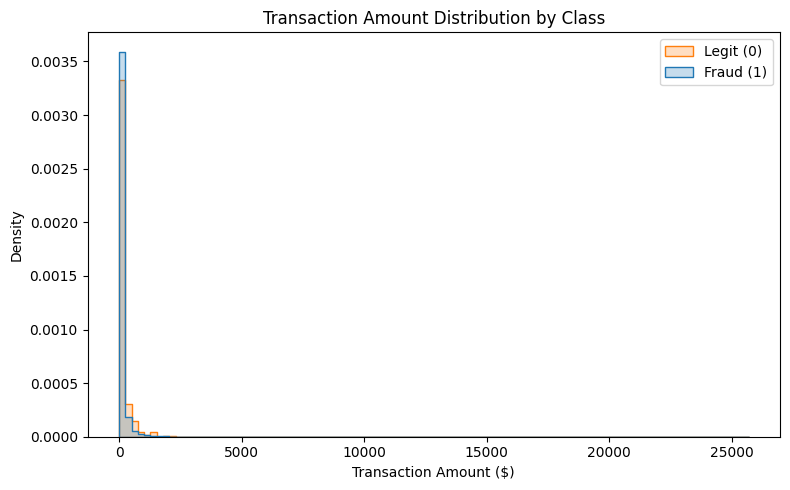

In [25]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='Amount', bins=100, hue='Class', element='step', stat='density', common_norm=False)
plt.title('Transaction Amount Distribution by Class')
plt.xlabel('Transaction Amount ($)')
plt.ylabel('Density')
plt.legend(labels=['Legit (0)', 'Fraud (1)'])
plt.tight_layout()
plt.show()


- Most transactions, whether fraud or legit, are low in value
- Fraudulent transactions often occur at lower amounts, possibly to avoid triggering alerts
- A few high-value frauds do exist but are rare


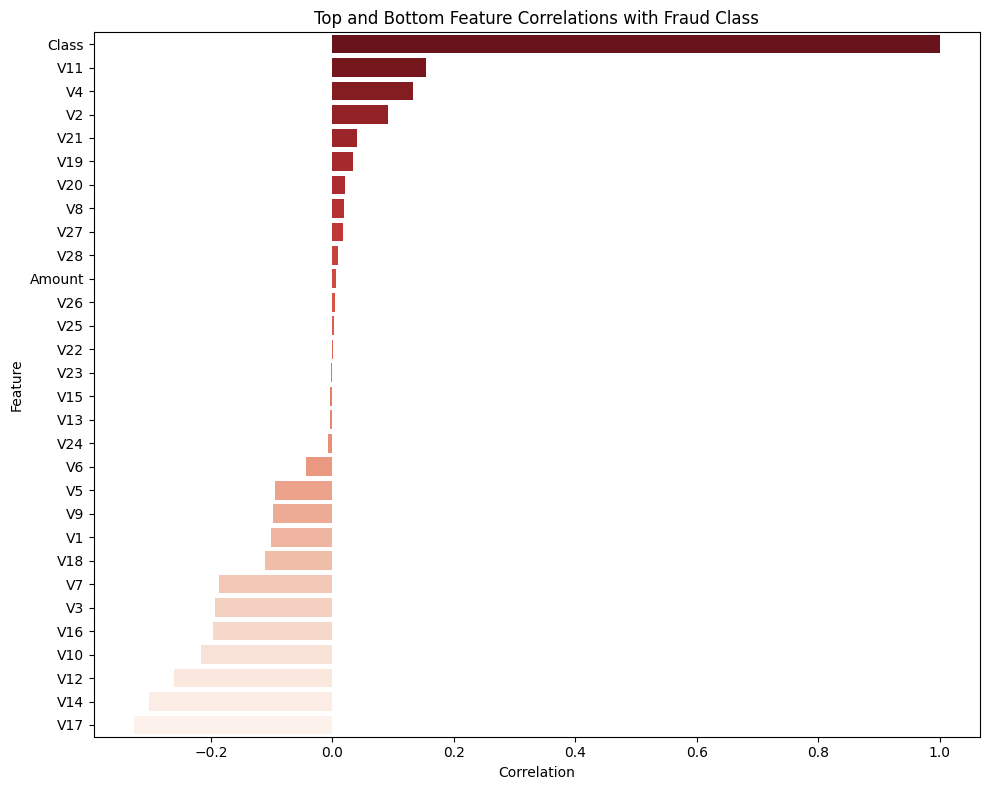

In [28]:
# Get top and bottom 15 correlated features with 'Class'
top_corr = correlations.head(15)
bottom_corr = correlations.tail(15)

# Combine into one DataFrame
combined_corr = pd.concat([top_corr, bottom_corr]).reset_index()
combined_corr.columns = ['Feature', 'Correlation']

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(
    data=combined_corr,
    x='Correlation',
    y='Feature',
    hue='Feature',
    dodge=False,
    palette='Reds_r',
    legend=False
)
plt.title('Top and Bottom Feature Correlations with Fraud Class')
plt.xlabel('Correlation')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


- Only a handful of features show notable correlation with fraud, including `V17`, `V14`, `V10`, and `V12` (negatively correlated), and `V11`, `V4`, and `V2` (positively correlated)
- The majority of features have low or negligible linear correlation with the target
- Both positively and negatively correlated features may carry important fraud signals
- All features are retained for modeling to preserve potential nonlinear or combined effects


We visualize the distribution of feature `V14` to compare its behavior across legitimate and fraudulent transactions.


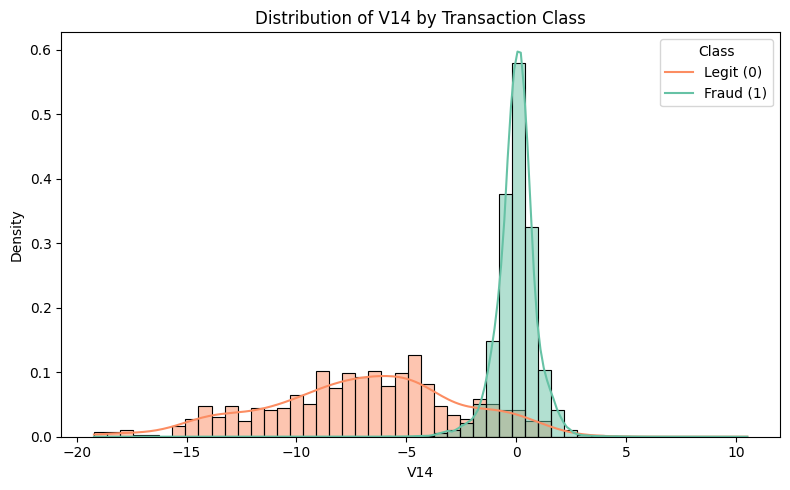

In [31]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='V14', hue='Class', bins=50, kde=True, stat='density', common_norm=False, palette='Set2')
plt.title('Distribution of V14 by Transaction Class')
plt.xlabel('V14')
plt.ylabel('Density')
plt.legend(title='Class', labels=['Legit (0)', 'Fraud (1)'])
plt.tight_layout()
plt.show()


- Fraudulent transactions cluster tightly around a small range of `V14` values, close to zero
- Legitimate transactions show a much wider spread, especially into negative values
- This strong separation confirms that `V14` is a key discriminative feature for identifying fraud


We visualize the distribution of feature `V10` to examine how it differs between fraudulent and legitimate transactions.


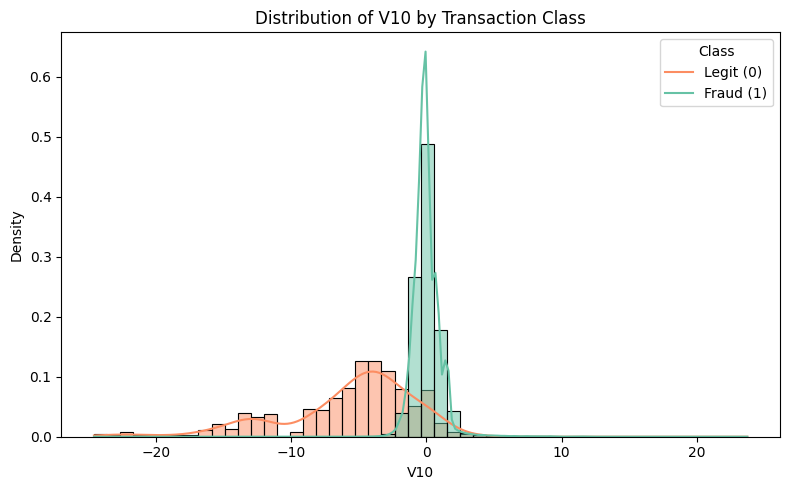

In [32]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='V10', hue='Class', bins=50, kde=True, stat='density', common_norm=False, palette='Set2')
plt.title('Distribution of V10 by Transaction Class')
plt.xlabel('V10')
plt.ylabel('Density')
plt.legend(title='Class', labels=['Legit (0)', 'Fraud (1)'])
plt.tight_layout()
plt.show()


- Fraudulent transactions are tightly clustered around a narrow band of `V10` values, peaking just above 0
- Legitimate transactions have a much wider and more spread-out distribution, especially toward large negative values
- The distinct separation between the two classes makes `V10` a strong candidate feature for detecting fraud


## Model Building and Evaluation

We compare classification models to detect fraudulent transactions. Given the class imbalance, we focus on metrics like precision, recall, and ROC AUC—rather than accuracy alone.


We begin by splitting the data into training and testing sets. We train a Decision Tree classifier using normalized features, controlled depth, and sample weighting to handle class imbalance.


In [38]:

# Train-test split using normalized features
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y, test_size=0.2, stratify=y, random_state=42
)

# Compute sample weights
w_train = compute_sample_weight(class_weight='balanced', y=y_train)

# Initialize Decision Tree with controlled depth
dt = DecisionTreeClassifier(max_depth=4, random_state=35)
dt.fit(X_train, y_train, sample_weight=w_train)

# Predict and evaluate
y_pred_dt = dt.predict(X_test)
y_pred_proba_dt = dt.predict_proba(X_test)[:, 1]

print("Decision Tree Classification Report:\n")
print(classification_report(y_test, y_pred_dt))

# ROC AUC
roc_auc_dt = roc_auc_score(y_test, y_pred_proba_dt)
print(f" Decision Tree ROC AUC Score: {roc_auc_dt:.4f}")


Decision Tree Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.05      0.89      0.09        98

    accuracy                           0.97     56962
   macro avg       0.52      0.93      0.54     56962
weighted avg       1.00      0.97      0.98     56962

 Decision Tree ROC AUC Score: 0.9660


### Decision Tree Performance

- The model achieved near-perfect performance on legitimate transactions (`Class = 0`) with 97% recall
- For fraudulent transactions (`Class = 1`), recall was high at 89%, but precision was very low (5%)—indicating many false positives
- Despite the low precision, the model is effective at catching fraud cases, which is often the priority in fraud detection
- The overall ROC AUC score of 0.9660 reflects strong discriminative power between the two classes



We train an SVM classifier using the normalized feature matrix and class weighting to address data imbalance.


In [35]:
# Re-split using normalized features for SVM
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y, test_size=0.2, stratify=y, random_state=42
)

# Train SVM with class_weight and probability enabled for ROC AUC
svm_model = SVC(class_weight='balanced', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_svm = svm_model.predict(X_test)
print("SVM Classification Report:\n")
print(classification_report(y_test, y_pred_svm))

# ROC AUC
y_pred_proba_svm = svm_model.predict_proba(X_test)[:, 1]
roc_auc_svm = roc_auc_score(y_test, y_pred_proba_svm)
print(f"ROC AUC Score for Support Vector Machine Model: {roc_auc_svm:.4f}")


SVM Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.38      0.89      0.53        98

    accuracy                           1.00     56962
   macro avg       0.69      0.94      0.77     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC Score: 0.9720


### SVM Performance

- The model achieved near-perfect results on legitimate transactions (`Class = 0`)
- For fraudulent transactions (`Class = 1`), recall reached 89% with significantly higher precision (38%) compared to the Decision Tree
- The improved precision suggests fewer false positives while still capturing most fraud cases
- The ROC AUC score of 0.9720 is slightly higher than the Decision Tree, indicating strong overall class separation
- This model provides a better balance between fraud detection and minimizing disruption to legitimate transactions


## Results & Key Insights

- Both models achieved high ROC AUC scores, indicating strong ability to distinguish fraud from legitimate transactions
    - Decision Tree ROC AUC: 0.9660
    - SVM ROC AUC: 0.9720

- The Decision Tree had higher recall (89%) but very low precision (5%) on fraud, meaning it caught most fraud but with many false alarms

- The SVM model maintained the same recall (89%) with significantly better precision (38%), resulting in fewer false positives

- While both models are viable, the SVM strikes a better balance between detecting fraud and minimizing disruption to non-fraudulent users

- Class imbalance handling (sample weighting) and proper preprocessing (feature normalization) were critical in improving model performance


## Business Recommendations

- Implement the fraud detection model as a real-time screening layer during transaction authorization.  
  The high recall ensures that most fraudulent activity will be flagged before completion.

- Because the SVM model offers better precision, it can reduce false positives and minimize disruption to legitimate customers—making it more suitable for deployment.

- Transactions flagged as fraudulent can be routed for manual review or temporary hold, depending on the risk threshold and operational capacity.

- Continue to monitor model performance in production using metrics like recall and precision, and retrain periodically with newer data to capture evolving fraud patterns.

- Consider combining predictive modeling with rule-based systems or anomaly detection to further reduce false positives without compromising fraud catch rates.


---

This project is part of a broader portfolio showcasing practical applications of data science across analytics, visualization, and machine learning.  
For more projects, visit [My GitHub Portfolio](https://github.com/J1111-dotcom).
